Index(['1_hifi_cov_xfold_grt_0bp_at_3Gbp', '2_hifi_length_N50_grt_0bp',
       '3_ont_cov_xfold_grt_100kbp_at_3Gbp', '4_ont_length_N50_grt_0bp',
       '5_ont_length_N50_grt_100kbp', '6_hap1_total_num_grt_0bp',
       '7_hap1_length_auN_grt_0bp', '8_hap2_total_num_grt_0bp', '9_wg_length',
       '9_hap2_length_auN_grt_0bp', '11_unassigned_total_length_grt_0bp',
       '12_unassigned_total_num_grt_0bp', '13_unassigned_length_auN_grt_0bp',
       '14_disconnected_total_length_grt_0bp',
       '15_disconnected_total_num_grt_0bp',
       '16_disconnected_length_auN_grt_0bp',
       '17_contaminants_total_length_grt_0bp',
       '18_contaminants_total_num_grt_0bp',
       '19_contaminants_length_auN_grt_0bp', '20_sseq_miso_inv',
       '21_sseq_switch_breaks', '22_paftools_gaps', '23_paftools_misjoins',
       '100_median'],
      dtype='object')


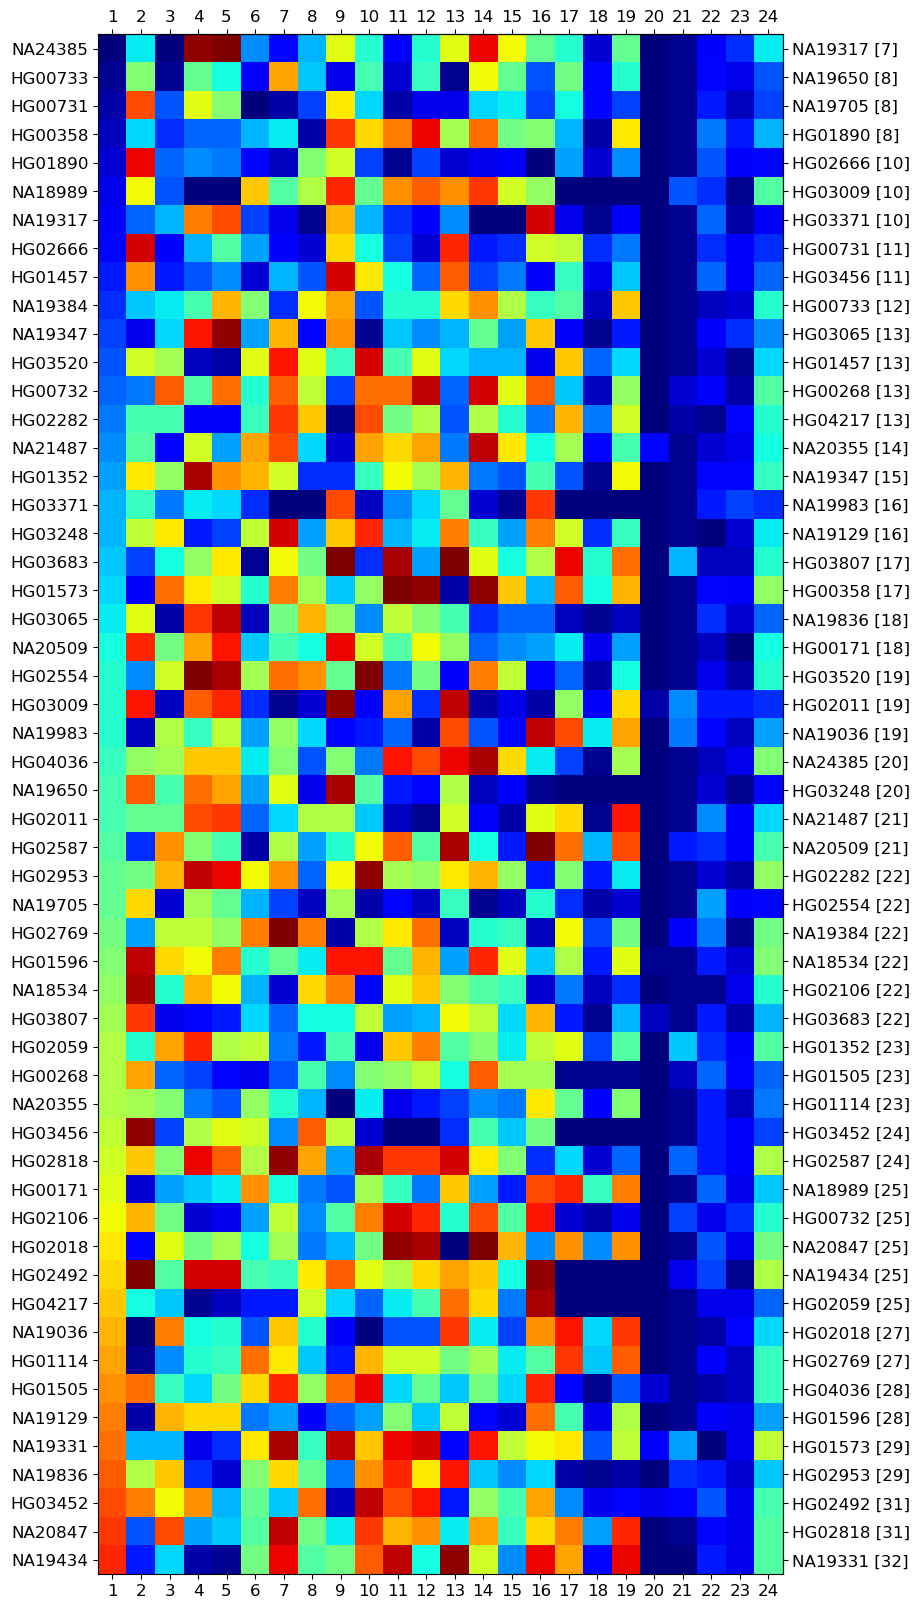

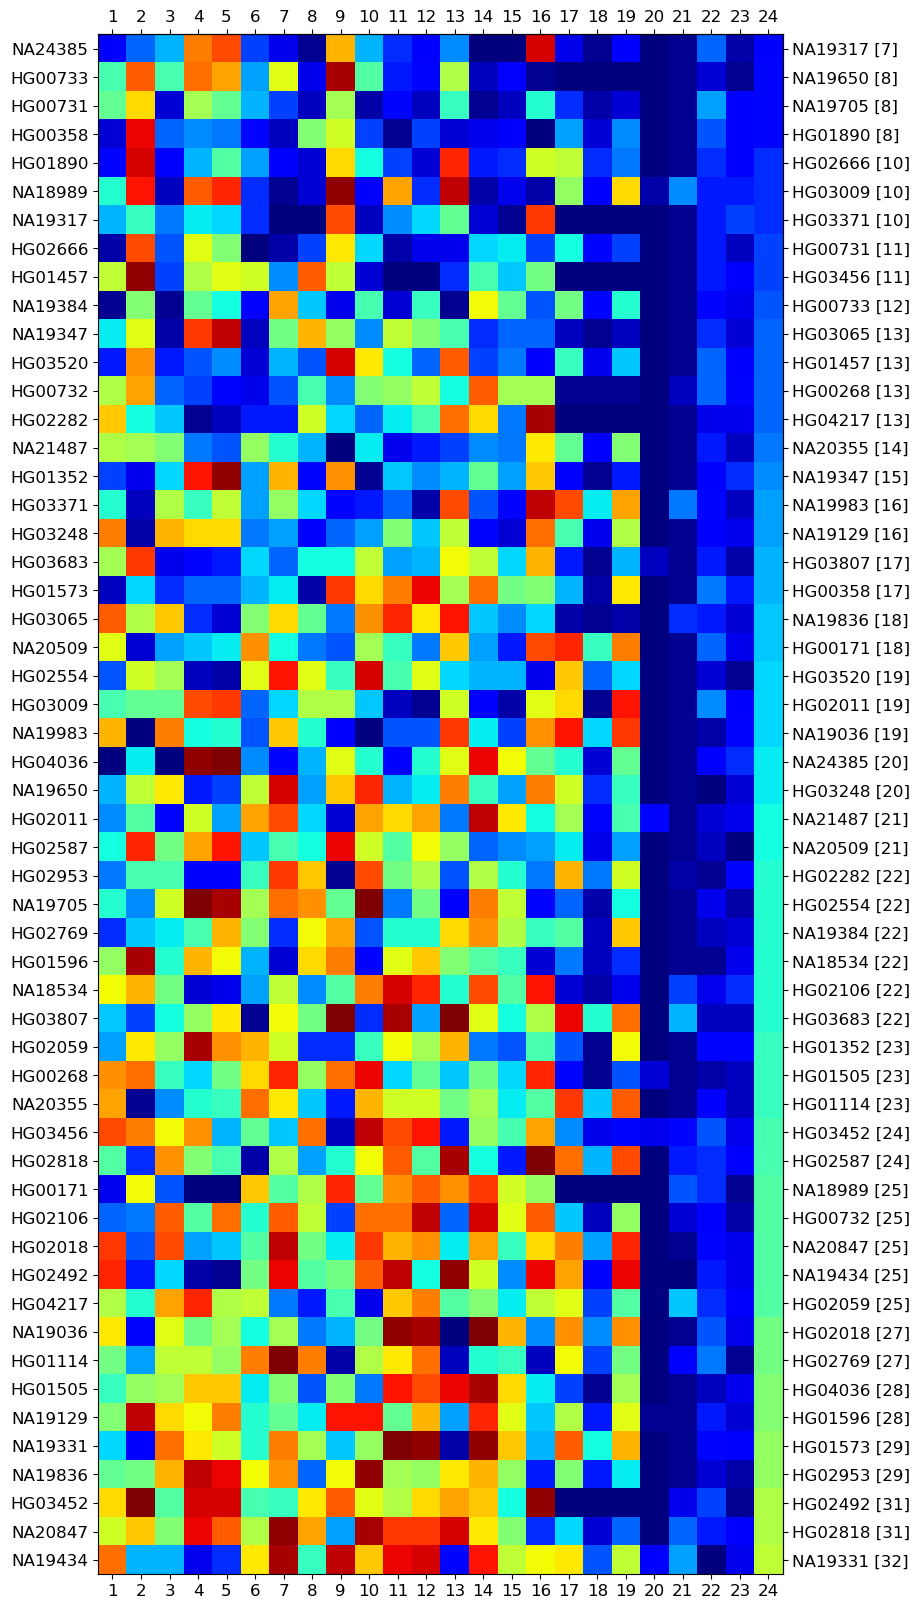

In [1]:
%run 00_project_config.ipynb

import pathlib as pl
import pandas as pd
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt


def read_norm_table(file_path):
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    return df


def rank_more_is_better(series):
    """rank 1 through N, higher values get lower rank"""
    return series.rank(method="dense", numeric_only=True, ascending=False, na_option="bottom")
    

def rank_less_is_better(series):
    """rank 1 through N, lower values get lower rank"""
    return series.rank(method="dense", numeric_only=True, ascending=True, na_option="bottom")


COLUMN_RANK_FUNCTIONS = dict()


# 2023-11-17:
# consider only samples from batch 1 and 2
batch_nums = [1, 2]
RANK_SAMPLES = HGSVC_SAMPLES.loc[HGSVC_SAMPLES["batch_num"].isin(batch_nums), "sample"].values

sample_ranking = []

# read stats
batch1_table = pl.Path("/home/ebertp/work/projects/hgsvc/2023_batch_data_tables/hgsvc3_batch1_read_stats.tsv")
batch2_table = pl.Path("/home/ebertp/work/projects/hgsvc/2023_batch_data_tables/hgsvc3_batch2_read_stats.tsv")

def extract_ranking_read_stats(stats_table, last_order=0):
    df = read_norm_table(stats_table)
    df = df.loc[df["sample"].isin(RANK_SAMPLES), :].copy()
    df = df.loc[df["source"] == "all", :].copy()
    relevant_hifi = ["cov_xfold_grt_0bp_at_3Gbp", "length_N50_grt_0bp"]
    relevant_ont = ["cov_xfold_grt_100kbp_at_3Gbp", "length_N50_grt_0bp", "length_N50_grt_100kbp"]
    
    column_order = last_order + 1
    all_stats = []
    for read_type in ["hifi", "ont"]:
        select_stats = relevant_hifi if read_type == "hifi" else relevant_ont
        
        sub = df.loc[df["read_type"] == read_type, :]
        for stat in select_stats:
            
            data = sub.loc[sub["statistic"] == stat, ["sample", "value"]]
            column_name = f"{column_order}_{read_type}_{stat}"
            data.rename(
                {"value": column_name},
                axis=1, inplace=True
            )
            data.set_index("sample", inplace=True)
            all_stats.append(data)
            column_order += 1
            COLUMN_RANK_FUNCTIONS[column_name] = rank_more_is_better
    all_stats = pd.concat(all_stats, axis=1, ignore_index=False)
    return all_stats, column_order

b1_read_stats, _ = extract_ranking_read_stats(batch1_table)
b2_read_stats, next_col_order = extract_ranking_read_stats(batch2_table)
sample_ranking = pd.concat(
    [b1_read_stats, b2_read_stats],
    axis=0, ignore_index=False
)

# assembly stats

def extract_ranking_assembly_stats(input_folder, next_col_order):

    asm_unit_order = {
        "hap1": next_col_order,
        "hap2": next_col_order+2,
        "unassigned": next_col_order+5,
        "disconnected": next_col_order+8,
        "contaminants": next_col_order+11
    }
    
    wg_length_column_order = asm_unit_order["hap2"]+1
    wg_length_column_name = f"{wg_length_column_order}_wg_length"
    COLUMN_RANK_FUNCTIONS[wg_length_column_name] = rank_more_is_better
    
    forward_next_col_order = asm_unit_order["contaminants"]+3
    
    all_stats = []
    wg_lengths = collections.Counter()
    for tsv_file in input_folder.glob("*summary.tsv"):
        file_parts = tsv_file.name.split(".")
        sample = file_parts[0]
        if sample not in RANK_SAMPLES:
            continue
        if "rdna" in tsv_file.name:
            continue
        asm_unit = file_parts[2].split("-")[-1]
        column_order = asm_unit_order[asm_unit]
        
        relevant_stats = [
            "total_length_grt_0bp",
            "total_num_grt_0bp",
            "length_auN_grt_0bp"
        ]
        df = read_norm_table(tsv_file)
        for stat in relevant_stats:
            try:
                stat_value = df.loc[df["statistic"] == stat, "value"].values[0]
            except IndexError:
                # can happen for contamination
                assert "contaminants" in tsv_file.name
                stat_value = 0
            if asm_unit in ["hap1", "hap2"] and "total_length" in stat:
                wg_lengths[sample] += stat_value
                continue
            column_name = f"{column_order}_{asm_unit}_{stat}"
            all_stats.append(
                (sample, column_name, stat_value)
            )
            column_order += 1
            if "hap1" in column_name or "hap2" in column_name:
                if "total_num" in column_name:
                    COLUMN_RANK_FUNCTIONS[column_name] = rank_less_is_better
                else:
                    COLUMN_RANK_FUNCTIONS[column_name] = rank_more_is_better
            else:
                COLUMN_RANK_FUNCTIONS[column_name] = rank_less_is_better
    
    all_stats.extend(
        [(sample, wg_length_column_name, length) for sample, length in wg_lengths.items()]
    )
        
    all_stats = pd.DataFrame.from_records(
        all_stats, columns=["sample", "column", "value"]
    )
    all_stats = all_stats.pivot(
        index="sample",
        columns="column",
        values="value"
    )
    
    return all_stats, forward_next_col_order

assembly_stats = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_assm_stats/verkko/eval_stage/summaries"
)
assm_stats, next_col_order = extract_ranking_assembly_stats(assembly_stats, next_col_order)

sample_ranking = pd.concat([sample_ranking, assm_stats], axis=1, ignore_index=False)
    

# sseq annotation / DAVID

def extract_sseq_ann_david(input_file, next_col_order):
    df = read_norm_table(input_file)
    select_length = df["width"] > int(1e6)  # regions >1Mbp assumed reliable
    select_state = df["states"] == "ww"
    sub = df.loc[select_length & select_state, :].copy()
    sub["sample"] = sub["assembly"].apply(lambda x: x.split("_")[0])
    agg = sub.groupby("sample")["length"].sum()
    column_name = f"{next_col_order}_sseq_miso_inv"
    agg.rename(column_name, inplace=True)
    COLUMN_RANK_FUNCTIONS[column_name] = rank_less_is_better
    forward_next_col_order = next_col_order + 1
    return agg, forward_next_col_order

sseq_ann_david_file = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_davidp_sseq_eval",
    "ssq_eval_allRegions.batch1-2.PEclean.tsv"
)
assm_stats, next_col_order = extract_sseq_ann_david(sseq_ann_david_file, next_col_order)

sample_ranking = pd.concat([sample_ranking, assm_stats], axis=1, ignore_index=False)
sample_ranking.fillna(0, inplace=True)

# sseq annotation / MIR

def extract_sseq_ann_mir(input_file, next_col_order):
    df = read_norm_table(input_file)
    df["length"] = df["interp_plain_max"] - df["interp_plain_min"]
    agg = df.groupby("sample")["length"].sum()
    column_name = f"{next_col_order}_sseq_switch_breaks"
    agg.rename(column_name, inplace=True)
    COLUMN_RANK_FUNCTIONS[column_name] = rank_less_is_better
    forward_next_col_order = next_col_order + 1
    return agg, forward_next_col_order

sseq_ann_mir_file = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_davidp_sseq_eval",
    "interpolated_linear_space_breakpoints.tsv"
)
assm_stats, next_col_order = extract_sseq_ann_mir(sseq_ann_mir_file, next_col_order)

sample_ranking = pd.concat([sample_ranking, assm_stats], axis=1, ignore_index=False)
sample_ranking.fillna(0, inplace=True)

# misjoins and gaps

def extract_misjoins_gaps(input_file, next_col_order):
    df = read_norm_table(input_file)
    sub = df.loc[df["location"] == "total", :].copy()
    agg = sub.groupby(["sample", "issue"])["count"].sum()
    agg = agg.reset_index(drop=False, inplace=False)
    agg = agg.pivot(index="sample", columns="issue", values="count")
    new_col_gap = f"{next_col_order}_paftools_gaps"
    new_col_misjoin = f"{next_col_order+1}_paftools_misjoins"
    COLUMN_RANK_FUNCTIONS[new_col_gap] = rank_less_is_better
    COLUMN_RANK_FUNCTIONS[new_col_misjoin] = rank_less_is_better
    agg.rename(
        {
            "gap": new_col_gap,
            "misjoin": new_col_misjoin
        }, axis=1, inplace=True
    )
    forward_next_col = next_col_order + 2
    return agg, forward_next_col

paftools_file = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_assm_misjoins",
    "paftools_misjoin_gap.hap-summary.tsv"
)

assm_stats, next_col_order = extract_misjoins_gaps(paftools_file, next_col_order)
sample_ranking = pd.concat([sample_ranking, assm_stats], axis=1, ignore_index=False)

###############################
### Render as heatmap / matrix
###############################

ranked_columns = []
row_labels_left = None
for column in sample_ranking.columns:
    rank_func = COLUMN_RANK_FUNCTIONS[column]
    ranked_values = rank_func(sample_ranking[column])
    if int(column.split("_")[0]) == 1:
        ranked_values.sort_values(inplace=True)
        ranked_columns.append(ranked_values.values)
        row_labels_left = ranked_values.index
    else:
        sort_by_sample = ranked_values[row_labels_left].values
        ranked_columns.append(sort_by_sample)

rank_matrix = pd.DataFrame(
    ranked_columns,
    columns=row_labels_left,
    index=sample_ranking.columns
)

rank_matrix = rank_matrix.transpose()

rank_matrix.sort_index(
    axis=1,
    inplace=True,
    key=lambda idx: pd.Index([int(col.split("_")[0]) for col in idx.values])
)


rank_matrix["100_median"] = rank_matrix.median(axis=1)

row_labels_right = rank_matrix["100_median"].sort_values()

row_labels_right = [f"{sample} [{int(rank)}]" for sample, rank in row_labels_right.items()]

print(rank_matrix.columns)

####################
## plot heatmaps
####################

fig, ax = plt.subplots(figsize=(20,20))

colormap = "jet"

ax.imshow(
    rank_matrix,
    cmap=colormap,
    norm=None,
    vmin=1,
    vmax=54
    
)
_ = ax.set_xticks(list(range(0, rank_matrix.shape[1])))
_ = ax.set_xticklabels(list(range(1, rank_matrix.shape[1]+1)), fontsize=12)

_ = ax.set_yticks(list(range(0, rank_matrix.shape[0])))
_ = ax.set_yticklabels(row_labels_left, fontsize=12)

x_second = ax.secondary_xaxis(location="top")
_ = x_second.set_xticks(list(range(0, rank_matrix.shape[1])))
_ = x_second.set_xticklabels(list(range(1, rank_matrix.shape[1]+1)), fontsize=12)

y_second = ax.secondary_yaxis(location="right")
_ = y_second.set_yticks(list(range(0, rank_matrix.shape[0])))
_ = y_second.set_yticklabels(row_labels_right, fontsize=12)


fig, ax = plt.subplots(figsize=(20,20))

colormap = "jet"

final_ranking = rank_matrix.sort_values("100_median", axis=0, inplace=False)

ax.imshow(
    final_ranking,
    cmap=colormap,
    norm=None,
    vmin=1,
    vmax=54
    
)
_ = ax.set_xticks(list(range(0, rank_matrix.shape[1])))
_ = ax.set_xticklabels(list(range(1, rank_matrix.shape[1]+1)), fontsize=12)

_ = ax.set_yticks(list(range(0, rank_matrix.shape[0])))
_ = ax.set_yticklabels(row_labels_left, fontsize=12)

x_second = ax.secondary_xaxis(location="top")
_ = x_second.set_xticks(list(range(0, rank_matrix.shape[1])))
_ = x_second.set_xticklabels(list(range(1, rank_matrix.shape[1]+1)), fontsize=12)

y_second = ax.secondary_yaxis(location="right")
_ = y_second.set_yticks(list(range(0, rank_matrix.shape[0])))
_ = y_second.set_yticklabels(row_labels_right, fontsize=12)
